<a href="https://colab.research.google.com/github/EscCoder/Machine_learning/blob/main/Energy_Consumption_Forecasting_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'buildingdatagenomeproject2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F787828%2F1601377%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241014%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241014T122855Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7eccc271875dee051e1c9071adb99e4ec0ef638286b97cf2cfbac6fa5ff5fe49197634920782706a24ee8c3027555b998010e11948c5f09ff86d619478d99911b12c27bda126f9ac0f17dbb78772f3300dc40979d7344a8554f30899b3acce040d013f3d4002a98fe1bd336a1247237ac6eb4d566b22b05edf49fc16446aa2c4aaa5176e654bb9bd81c97e018fdc5b80b89e858fb8e23a2a0eaea8905691195d6aa3d9345c28a737e1fe5e02ab7acea707d42abb8457af71978c7149496c288923cd226b8bd505f0f6597f3fba05ca1949a1d576b3109cc22ea62d5c27cf1ab4ef55c4bcd16d4a8290f10946a1d9b577a837e2aec5ce04caa544680cfd5e2056'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 275651227 bytes downloaded
Downloaded and uncompressed: buildingdatagenomeproject2
Data source import complete.


Import relevant python packages



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

Next let's load all the packages we will need for  analysis

In [3]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime

## Load electricity data and weather data

First we can load the data from the BDG in the same as our previous weather analysis influence notebook from the Construction Phase videos

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 1578 entries, Panther_parking_Lorriane to Mouse_science_Micheal
dtypes: float64(1578)
memory usage: 211.3 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB


<ipython-input-5-f081a1d3cf16>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  office_example_prediction_data = pd.DataFrame(elec_all_data[buildingname].truncate(before='2017-01-01')).fillna(method='ffill')


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2017-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   site_id         8760 non-null   object 
 1   airTemperature  8760 non-null   float64
 2   cloudCoverage   5047 non-null   float64
 3   dewTemperature  8760 non-null   float64
 4   precipDepth1HR  8752 non-null   float64
 5   precipDepth6HR  329 non-null    float64
 6   seaLvlPressure  8522 non-null   float64
 7   windDirection   8511 non-null   float64
 8   windSpeed       8760 non-null   float64
dtypes: float64(8), object(1)
memory usage: 684.4+ KB


<ipython-input-5-f081a1d3cf16>:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_hourly = weather_data_site.select_dtypes(include=np.number).resample("H").mean()
<ipython-input-5-f081a1d3cf16>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')


<Axes: xlabel='timestamp'>

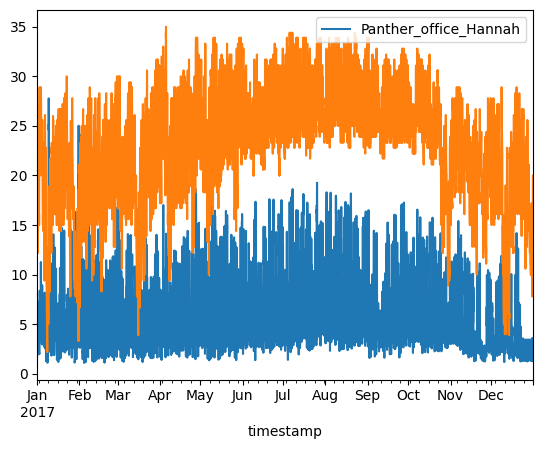

In [5]:
elec_all_data = pd.read_csv("../input/buildingdatagenomeproject2/electricity_cleaned.csv", index_col='timestamp', parse_dates=True)
elec_all_data.info()
buildingname = 'Panther_office_Hannah'
office_example_prediction_data = pd.DataFrame(elec_all_data[buildingname].truncate(before='2017-01-01')).fillna(method='ffill')
office_example_prediction_data.info()
office_example_prediction_data.plot()
weather_data = pd.read_csv("../input/buildingdatagenomeproject2/weather.csv", index_col='timestamp', parse_dates=True)
weather_data_site = weather_data[weather_data.site_id == 'Panther'].truncate(before='2017-01-01')
weather_data_site.info()
weather_hourly = weather_data_site.select_dtypes(include=np.number).resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')
temperature = weather_hourly_nooutlier_nogaps["airTemperature"]
temperature.plot()

 Create Train and Test Datasets

The model is given a set of data that will be used to **train** the model to predict a specific objectice. In this case, we will use a few simple time series features as well as outdoor air temperature to predict how much energy a building uses.

For this demonstration, we will use three months of data from April, May, and June to prediction July.

In [6]:
training_months = [4,5,6]
test_months = [7]

We can divide the data set by using the `datetime index` of the data frame and a function known as `.isin` to extract the months for the model

In [7]:
trainingdata = office_example_prediction_data[office_example_prediction_data.index.month.isin(training_months)]
testdata = office_example_prediction_data[office_example_prediction_data.index.month.isin(test_months)]

In [8]:
trainingdata.info()
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2017-04-01 00:00:00 to 2017-06-30 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2017-07-01 00:00:00 to 2017-07-31 23:00:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Panther_office_Hannah  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


We can extract the training input data features that will go into the model and the training **label** data which is what are are targeting to predict.

Encoding Categorical Variables

We use the pandas `.get_dummies()` function to change the temporal variables of *time of day* and *day of week* into categories that the model can use more effectively. This process is known as [enconding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [9]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour),
                                     pd.get_dummies(trainingdata.index.dayofweek),
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()


In [10]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,21.7
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,21.0
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,18.9
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,20.6
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,21.0


Train a K-Neighbor Model

This model was chosen after following the process in the cheat sheet until a model that worked and provided good results was found.

In [11]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));


In [12]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())



 Use the Model to predict for the *Test* period

Then the model is given the `test_features` from the period which we want to predict. We can then merge those results and see how the model did

In [13]:
predictions = model.predict(test_features)

In [14]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [15]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2017-07-01 00:00:00,5.3370,5.21720
2017-07-01 01:00:00,3.8547,4.75674
2017-07-01 02:00:00,5.5751,3.76374
2017-07-01 03:00:00,4.1248,3.59868
2017-07-01 04:00:00,3.3497,5.34042


<Axes: xlabel='timestamp'>

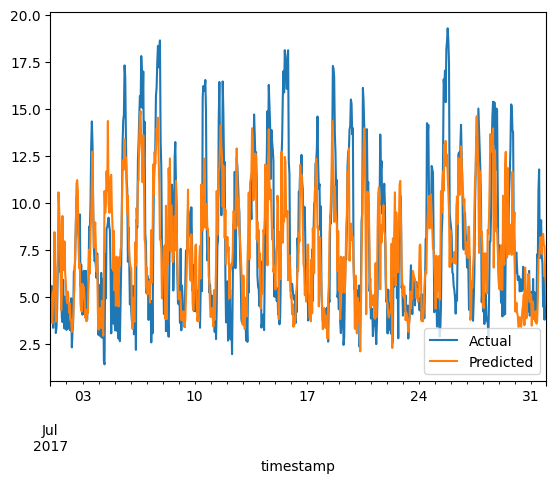

In [16]:
predicted_vs_actual.plot()

<Axes: xlabel='timestamp'>

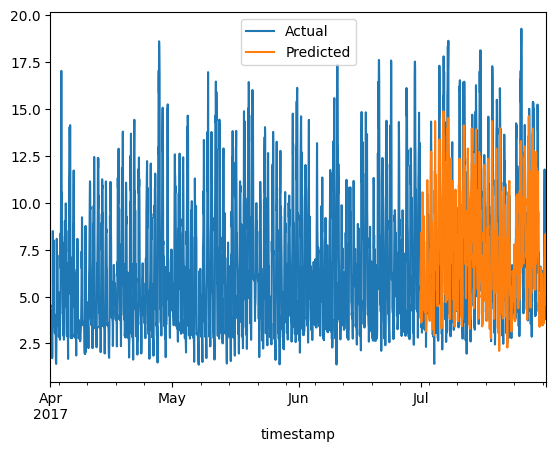

In [17]:
trainingdata.columns = ["Actual"]
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)
predicted_vs_actual_plus_training.plot()

 Evaluation metrics

In order to understand quanitatively how the model performed, we can use various evaluation metrics to understand how well the model compared to reality.

In this situation, let's use the error metric [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)

In [18]:
# Calculate the absolute errors
errors = abs(predicted_vs_actual['Predicted'] - predicted_vs_actual['Actual'])
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / predicted_vs_actual['Actual']))